# Covariance and Correlation

In this notebook we'll start to think about how to quantify the similarities within our dataset.  Let's get `NumPy` imported first:

In [1]:
import numpy as np
import math

As we discussed in the beginning of this course, there is a very good chance that the spatiotemporal data you work with will be linearly dependent on one another.  Often this arises because the processes that generated the phenomena that are the source of your data impart this similarity or that our data reflect some common underlying influences or controls.  Spatiotemporal data are, by their nature, linked to a particular time and space.  

This dependence within our data is both a challenge and an opportunity.  The ultimate goal of this class is for us to learn and understand methods that allow us to characterize this dependence, isolate it, remove it, or use it to our advantage.  Or, in otherwords, our methods for analyzing data in this class arise out of the need to deal with dependent and ill-conditioned data in solving systems of linear equations.

To start then, we want to quantify how similar our data are to one another (and, eventually, to other data as well).  We seek to identify similarity in our data in order to isolate and analyze it, or get rid of it so we can meet the requirements of other types of analysis.  

This will take us into the realm of simple statistics.  Remember a few definitions:

* a **sample** is the set of data, observations, etc. currently available and under our study
* the **population** is the complete set of all possible elements, outcomes, or measurements of a phenomenon
* our sample is therefore some subset of all possible observations of the true population

You are probably familiar with a range of simple statistical measures to characterize or describe data.  For instance, the mean is a measure of the central tendency of our data:

$
\bar{x} = \frac{1}{n}\sum_{i}^{n} x_i
$

In Python or NumPy, we can get the mean of a vector (or array or matrix) :

In [2]:
x = np.array([[1,2,3,4,5,6]])

# by the definition of the mean, we could calculate the sum and divide by the sample size
print((1 + 2 + 3 + 4 + 5 + 6)/6)

# we could ask Python to help us by calculating the sum and giving us the same size
print(x.sum()/x.size)

# We could use the np.mean function
print(np.mean(x))

# or we could use the mean method on the object itself
print(x.mean())

3.5
3.5
3.5
3.5


All of the approaches above -- from using Python as a calculator to using the object oriented nature of Python -- give us a mean value of 3.5 for our simple vector. 

It is worth pausing for a moment to ask what happens when we have a missing value or 'Not A Number' (NaN) in our vector:

In [3]:
y = np.array([[1, 2, 3, np.nan, 5, 6]])
y.mean()

nan

You can see that the mean of a vector with a NaN value is returned as NaN.  Missing data are a fact of life -- the sensor broke, quality control removed a bad number, the researcher wasn't able to make it to the field that day, the subject disappeared, etc. etc.  How do we deal with missing values? 

Fortunately, in NumPy, there are a host of methods that can account for NaNs - for instance, we can use `np.nanmean` to calculate the mean value of $y$ while ignoring the NaN value:

In [4]:
np.nanmean(y)

3.4

Alternatively, we could use `np.isnan` to create a Boolean mask for our array, and then specify that np.mean should only consider those values that are non NaN:

In [5]:
valid = ~np.isnan(y) # basically 'tell me where np.isnan(y) is not a NaN, returns [[ True  True  True False  True  True]]
print(np.mean(y[valid])) # np.mean as function
print(y[valid].mean()) # .mean() on object

3.4
3.4


As we continue through the class, we'll also see ways to deal with NaNs in the Pandas and xarray libraries. 

Our next statistical measure of a series of data is _variance_, which is a measure of dispersion (spread or variability) around the mean value. The equation for variance is:

$
\sigma^2 = \frac{1}{n-1}\sum_{i}^{n} (x_i - \bar{x})^2
$

Variance therefore is the sum of the differences between each individual value in the series and the mean of the series squared, then divided by the sample size less 1 (n-1 gives us what is called the ['unbiased' estimator](https://en.wikipedia.org/wiki/Bessel%27s_correction) of the variance, because we are already estimating the mean value from the _sample_, not the population in full). 

Once again, we could do this 'by hand', going through each term, subtracting the mean, squaring the difference, summing the difference, and then multipling by the sample size less one.  But that sounds like a lot of work.   However, matrix algebra suggests a way to do this in a much easier way.  If you look at the equation above, the difference between each term in the series and the mean is being _squared_, which is a lot like multiplying that difference term by itself.  Also, at the end we are summing all those squared terms, which sounds a lot like what we do with the dot product we learned about in the Linear Algebra notebook!  How do we do this?

In [6]:
# first, remove the mean from each of the individual terms
xi = x - np.mean(x) 

# then, get the dot product of xi with itself and multiply by 1/n-1
x_var = np.dot(xi,xi.T)/(np.size(x)-1)

# let's see the answer
print(x_var)

[[3.5]]


Of course, we could also use [the built-in function for `np.var`](https://numpy.org/doc/stable/reference/generated/numpy.var.html) as well - let's use it check out answer:

In [7]:
print(np.var(x,ddof=1)) # note that we have to specify the 'Delta Degrees of Freedom' or ddof

3.5


Success! - Note though that the default for `np.var` is to calculate the _biased_ estimator, while we wanted to the unbiased estimator, and we had to specify the `ddof=1` to do that (this tells Python to subtract 1 from the sample size).  What this sequence of calculations suggests is that (**1**) matrix algebra -- and specifically matrix multiplication -- provide a tractable way to perform statistical operations even in the absense of the built-in functions, but perhaps more importantly (**2**) it emphasizes that the variance of a system is a function of the dot product of a (centered, zero-mean) vector with itself!

Let's briefly look at the standard deviation, which is related to the variance of a vector.   In fact, the standard deviation (another measure of dispersion around the mean) is just the square root of the variance:

$
\sigma = \sqrt{\frac{1}{n-1}\sum_{i}^{n} (x_i - \bar{x})^2}
$

As above, we could calculate this using matrix operations, or simply call the built-in function

In [8]:
# matrix operations
x_std = math.sqrt(np.dot(xi,xi.T)/(np.size(x)-1))
print(x_std)

# built in function
print(np.std(x,ddof=1))

1.8708286933869707
1.8708286933869707


Thus far we've looked at a single sample, or vector, or series of numbers.  But as we know, in this class our data will consist of many, perhaps hundreds or thousands of series of data - column upon column of variables (often at different locations) and rows and rows of observations of those variables through time.  The concept and measurement of _**covariance**_ therefore is important.  Covariance is a measure of how two series change together.  Do they go up and down together around their respective mean values?  Are they in opposition, with one being relatively high compared to their mean value when the other is anomalously low? Or is there no relationship.  If we can quantify how similar (or dissimilar) a set of time series are to one another, we are on our way to being able to identify, deal with, or take advantage of linear dependence betweent them.

The covariance of two series $x$ and $y$ having the same length $n$ is defined as:

$
cov(x,y) = \frac{1}{n-1}\sum_{i}^{n} (x_i - \bar{x})(y_i - \bar{y})
$

In words, we remove the mean from each series, but now instead of squaring that difference (or, getting the product of those centered values with themselves), we get the product of the anomalies from each series, or vector, or column of data.  We then sum these as we did with the variance calculation and multiply by the sample size less one ($n-1$).  

Once again, this looks like a dot product, right!?  We're going to multiply a bunch of values and then sum those products.  Now instead of one series, though, we have two:

In [9]:
x = np.array([-4, -1, 1, 3, 1, 6])
y = np.array([-4, 2, -1, 2, 2, 5])

As above, let's do the covariance calculation using matrix operations:

In [10]:
# remove the mean from each of the individual terms
xi = x - np.mean(x) 
yi = y - np.mean(y)

# get the dot product of xi with itself and multiply by 1/n-1
xy_cov = np.dot(xi.T,yi)/(np.size(x)-1)

print(xy_cov)

9.0


Let's check using the built-in function, `np.cov`:

In [11]:
np.cov(x,y,ddof=1)

array([[11.6,  9. ],
       [ 9. ,  9.6]])

What we see here is somewhat different that what we calculated above, because what the built-in function has done is consider $x$ and $y$ not as separate vectors, but as 2 vectors in a single matrix:

In [12]:
# join the two centered vectors into a single matrix
xyi = np.vstack((xi,yi))
print(xyi)

[[-5. -2.  0.  2.  0.  5.]
 [-5.  1. -2.  1.  1.  4.]]


In [13]:
# now, take the dot product of that matrix with itself
xy_cov2 = np.dot(xyi,xyi.T)/(np.size(x)-1)
print(xy_cov2)


[[11.6  9. ]
 [ 9.   9.6]]


Ah hah! There we go.  What does this output tell us?  Well, we got the dot product of a matrix with 2 rows and 6 columnns.  Because we transposed the second term in the dot product, the matrix multiplication was therefore of one matrix of size 2x6 with another matrix of 6x2 - the inner dimensions of 6 matched, and the result of the dot product was a 2x2 matrix.  But what are the elements of this matrix?  What we see is that the covariance we calculated above (9) appears on the off-diagonal elements.  Or, in otherwords, in the 1st row and 2nd column, and in the 2nd row and 1st column.  On the diagonals are two different numbers.  What do they represent?

If you said 'the variance of the individual series', you're absolutely correct!  The off-diagonal elements are the covariance of each series with the other, while the diagonal entries (row 1, column 1 and row 2, column 2) are the variances of each series individually (or, if you like, _the covariance of each series with itself!_).  We can prove that to ourselves as well:

In [14]:
print(np.var(x,ddof=1))
print(np.var(y,ddof=1))

11.6
9.6


Another measure of similarity we often use is the correlation, quite typically the [Pearson Product Moment Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) although there are other types.  The correlation is related to the covariance, but normalizes by the variance of each series being compared so that the result of the correlation calculation is a coefficient always falling between -1 and 1, giving us an easy way to quantify the similarity of two series even if they have very different levels of dispersion around their respective mean or different overall magnitudes and absolute values.  We can express the Pearson correlation as:

$
r_{x,y} = \frac{1}{n-1}\sum_{i=1}^n  \Big( \frac{x_i - \bar{x}}{\sigma_x} \Big)  \Big( \frac{y_i - \bar{y}}{\sigma_y} \Big) 
$

As I warned you, there are often several ways of doing the same or similar calculations in Python, and this is true for correlation.  In fact, we find functions to do correlation in `NumPy`, `SciPy`, and `Pandas`.

Probably because `NumPy` is used for numerical calculations primarily, you can get a correlation matrix using `numpy.corrcoef`, but this function does not provide significance levels to allow you to evaluate the meaningfulness of the correlation coefficient. 

`SciPy` is a statistical library, and so provides several ways of doing correlation, including `scipy.stats.pearsonr`.  It can calculate correlation and significance but usually for one series against another, not in a matrix form - it considers one series at a time. 

Finally, `Pandas` provides its own correlation function that you can use to operate on `DataFrames`, but does not natively provide significance levels. We need to use an additional _callable function_ to get the significance levels, as I'll show below.

Here is a demonstration of some of these approaches:

In [15]:
# let's get SciPy and Pandas
import scipy as sp
from scipy.stats import pearsonr # get the function directly, we'll see why in a moment

import pandas as pd

# let's make our row matrix a column matrix:
xy = xyi.T

# use NumPy to get the correlation, but no significance values are returned
corr_np = np.corrcoef(xy[:,0],xy[:,1])
print(np.round(corr_np,2))
      
# Let's see SciPy do it - we get the same correlation, no matrix, but we get a significance level
corr_sp = sp.stats.pearsonr(xy[:,0],xy[:,1])
print(np.round(corr_sp,2))

# Finally, let's see what Pandas will do
df1 = pd.DataFrame(xy) # make a Pandas DataFrame
print(np.round(df1.corr(method='pearson'),2))


[[1.   0.85]
 [0.85 1.  ]]
[0.85 0.03]
      0     1
0  1.00  0.85
1  0.85  1.00


All of these do give us similar information - our two test series $x$ and $y$ are correlated at $r=0.85$ and `SciPy` tells us the p-value (significance) is $p=0.03$.  But I find all of these approaches unsatisfying - what I'd like is a matrix of correlation values, like `NumPy` returns, but I want a similar matrix of significance values.  None of the approaches above provide this out of the box, incredibly! 

`Pandas` does provide us with workaround though.  In addition to being able to specify which correlation methods to use (e.g. `method='pearson'`), Pandas allows us to call another function using the _**lambda**_ approach - see here: https://realpython.com/python-lambda/

In essence, this lets us write anonymous functions on a single line, without having to write an entire function.  I won't go into any more detail here for the moment, but combining Panda's correlation method with the Pearson's R calculation in SciPy will get us the two matrices we want:



In [16]:
# first, we ask Panda's corr method to use the lambda function, calling SciPy's pearsonr, and returning only the first value, the coefficient
correlation_matrix = df1.corr(method=lambda x, y: pearsonr(x, y)[0])

# second, we ask Panda's corr method to use the lambda function, calling SciPy's pearsonr, and returning only the second value, the p-value
pvalues = df1.corr(method=lambda x, y: pearsonr(x, y)[1])

print(correlation_matrix)
print(pvalues)

         0        1
0  1.00000  0.85286
1  0.85286  1.00000
          0         1
0  1.000000  0.030882
1  0.030882  1.000000


Sort of maddenning, but I guess no language is perfect.  This solution comes from [here](https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance).  

When we learn about writing our own function, you might elect to write your own utility or helper function that does this for you!

It seems our two short series are pretty similar - although there are only 6 observations of each variable, they are well-correlated.  As a final look, let's make simple plot of them using `matplotlib`:

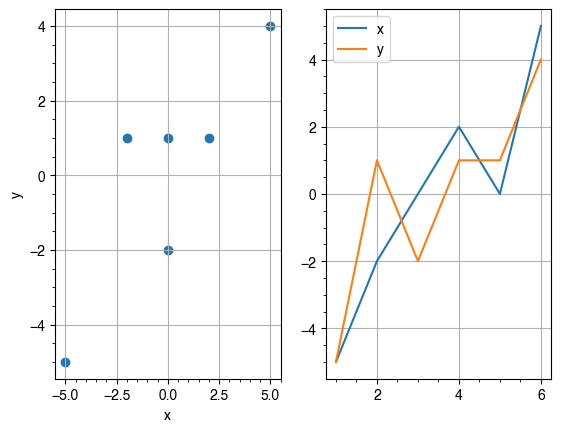

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica'

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(xy[:,0], xy[:,1])  # scatter plot on the first axis
ax1.minorticks_on()
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

lx1,lx2 = ax2.plot(np.arange(1, 7), xy)
ax2.minorticks_on()
ax2.grid()
ax2.legend([lx1,lx2],['x','y'])

plt.show()


We've now got the background knowledge and the programming basics to start to think about how we can quantify similarities (and dissimilarities) in our dataset.  In the coming weeks, we'll see how this leads us to the ability to isolate and reconfigure that similarity for our own purposes.  You can also see [Part 2](https://github.com/kanchukaitis/spatiotemporal_data_analysis/blob/main/03_covariance/covariance_correlation_part2.ipynb) of this lesson, where we chart a course from matrix algebra through covariance toward what we're after -- empirical orthongonal functions. 